# Testing models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

In [2]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'

- SEX_A : sex
- URBRRL : urban-rural classification
- MARITAL_A : married, living with partner, neither
- ANXEV_A : ever had anxiety disorder
- DEPEV_A : ever had depression
- SHTCVD191_A : was covid vaccinated
- HISPALLP_A : race
- SMKCIGST_A : smoker status
- RATCAT_A : income to poverty threshold (ordinal)
- MEDRXTRT_A : weakened immune system
- EDUCP_A : education level, (ordinal, 97, 99 are NA)
- ARTHEV_A : ever had arthritis

In [3]:
chi_feats = ['SEX_A', 'URBRRL', 'MARITAL_A', 
                   'ANXEV_A', 'SHTCVD191_A', 'HISPALLP_A', 
                   'DEPEV_A', 'SMKCIGST_A', 'RATCAT_A', 
                   'MEDRXTRT_A', 'EDUCP_A', 'ARTHEV_A']
df_full.loc[:, chi_feats].isna().sum()

SEX_A          0
URBRRL         0
MARITAL_A      0
ANXEV_A        0
SHTCVD191_A    0
HISPALLP_A     0
DEPEV_A        0
SMKCIGST_A     0
RATCAT_A       0
MEDRXTRT_A     0
EDUCP_A        0
ARTHEV_A       0
dtype: int64

In [60]:
## PREPROCESSING CHI FEATURES
def preprocess_chi_features(df_full):
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    
    chi_feats = ['SEX_A', 'URBRRL', 'MARITAL_A', 
                   'ANXEV_A', 'SHTCVD191_A', 'HISPALLP_A', 
                   'DEPEV_A', 'SMKCIGST_A', 'RATCAT_A', 
                   'MEDRXTRT_A', 'EDUCP_A', 'ARTHEV_A']
    df_chi = df_full[chi_feats]
    df_chi[y_name] = df_full[y_name]
    df_chi = df_chi.dropna(subset=y_name)
    df_chi = df_chi[df_chi[y_name] != 9]

    # edit EDUCP_A
    df_chi['EDUCP_A'][df_chi['EDUCP_A'] > 10] = 0
    
    encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
    scaler = StandardScaler().set_output(transform="pandas")
    
    X = df_chi.drop(columns=y_name)
    
    # define continuous and categorical features
    continuous = ['RATCAT_A', 'EDUCP_A']
    categorical = X.columns[~X.columns.isin(continuous)]
    
    # scale and encode
    cont_df =  scaler.fit_transform(X.loc[:, continuous])
    cat_df = encoder.fit_transform(X.loc[:,categorical])
    
    processed_df = pd.concat((cont_df, cat_df), axis=1)
    ## END PREPROCESSING
    
    X = processed_df.copy()
    y = df_chi.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test spchi
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)
    return X_train, X_test, y_train, y_test, scaler, encoder

In [61]:
X_train, X_test, y_train, y_test, scaler, encoder = preprocess_chi_features(df_full)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_23262/866691815.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi[y_name] = df_full[y_name]
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_23262/866691815.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = va

In [20]:
unknowns_cols = X_train.filter(regex='_9$|_7$|_8$').columns
other_cols = X_train.columns[~X_train.columns.isin(unknowns_cols)]
urban_cols = X_train.filter(regex='URBRRL').columns
[i for i, col in enumerate(X_train.columns) if col in unknowns_cols]
[i for i, col in enumerate(X_train.columns) if col in other_cols]

[0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 13,
 16,
 20,
 21,
 22,
 23,
 24,
 26,
 29,
 30,
 31,
 32,
 34,
 37]

In [21]:
coords = {"coeffs":X_train.columns}

with pm.Model(coords=coords) as hier_chi_model:
    # data containers
    X = pm.Data("X", X_train.values)
    y = pm.Data("y", y_train)

    mu = 0

    # No shrinkage on intercept
    b0 = pm.Normal("beta0", 0, 100)

    mu += b0 # add intercept

    # GROUP UNKNOWN ENTRIES
    unknowns_cols = X_train.filter(regex='_9$|_7$|_8$').columns
    unknowns_idx = [i for i, col in enumerate(X_train.columns) if col in unknowns_cols]
    unknowns_mu = pm.Normal(f"unknowns_mu", mu=0, sigma=1)
    unknowns_sigma = pm.HalfNormal(f"unknowns_sigma", sigma=1)
    for i, unknown in zip(unknowns_idx, unknowns_cols):
        b = pm.Normal(f"b_{unknown}", mu=unknowns_mu, sigma=unknowns_sigma)
        # mu += pm.math.dot(X_train.loc[:, unknown].values, b)
        mu += X[:, i] * b

    # GROUP URBAN/RURAL ENTRIES
    urban_cols = X_train.filter(regex='URBRRL').columns
    urban_idx = [i for i, col in enumerate(X_train.columns) if col in urban_cols]
    urban_mu = pm.Normal(f"urban_mu", mu=0, sigma=1)
    urban_sigma = pm.HalfNormal(f"urban_sigma", sigma=1)
    for i, urban in zip(urban_idx,urban_cols):
        b = pm.Normal(f"b_{urban}", mu=urban_mu, sigma=urban_sigma)
        # mu += pm.math.dot(X_train.loc[:, urban].values, b)
        mu += X[:, i] * b

    other_cols = X_train.columns[~X_train.columns.isin(np.hstack((unknowns_cols,urban_cols)))]
    other_idx = [i for i, col in enumerate(X_train.columns) if col in other_cols]

    for i, single in zip(other_idx, other_cols):
        b = pm.Normal(f"b_{single}", mu=0, sigma=1)
        # mu += pm.math.dot(X_train.loc[:, single].values, b)
        mu += X[:, i] * b
        

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
hier_chi_model

          beta0 ~ Normal(0, 100)
    unknowns_mu ~ Normal(0, 1)
 unknowns_sigma ~ HalfNormal(0, 1)
      b_SEX_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
      b_SEX_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
  b_MARITAL_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
  b_MARITAL_A_8 ~ Normal(unknowns_mu, unknowns_sigma)
  b_MARITAL_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
    b_ANXEV_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
    b_ANXEV_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
b_SHTCVD191_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
b_SHTCVD191_A_8 ~ Normal(unknowns_mu, unknowns_sigma)
b_SHTCVD191_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
 b_HISPALLP_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
    b_DEPEV_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
    b_DEPEV_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
 b_SMKCIGST_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
 b_MEDRXTRT_A_7 ~ Normal(unknowns_mu, unknowns_sigma)
 b_MEDRXTRT_A_9 ~ Normal(unknowns_mu, unknowns_sigma)
   b_ARTHEV_A_7 ~ Normal(unknowns_mu,

In [22]:
with hier_chi_model:
    idata_hier_chi = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/Users/katherinehunter/Github/bayesian-lcovid/.venv/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (12277), generating only 20 plots
  warnings.warn(


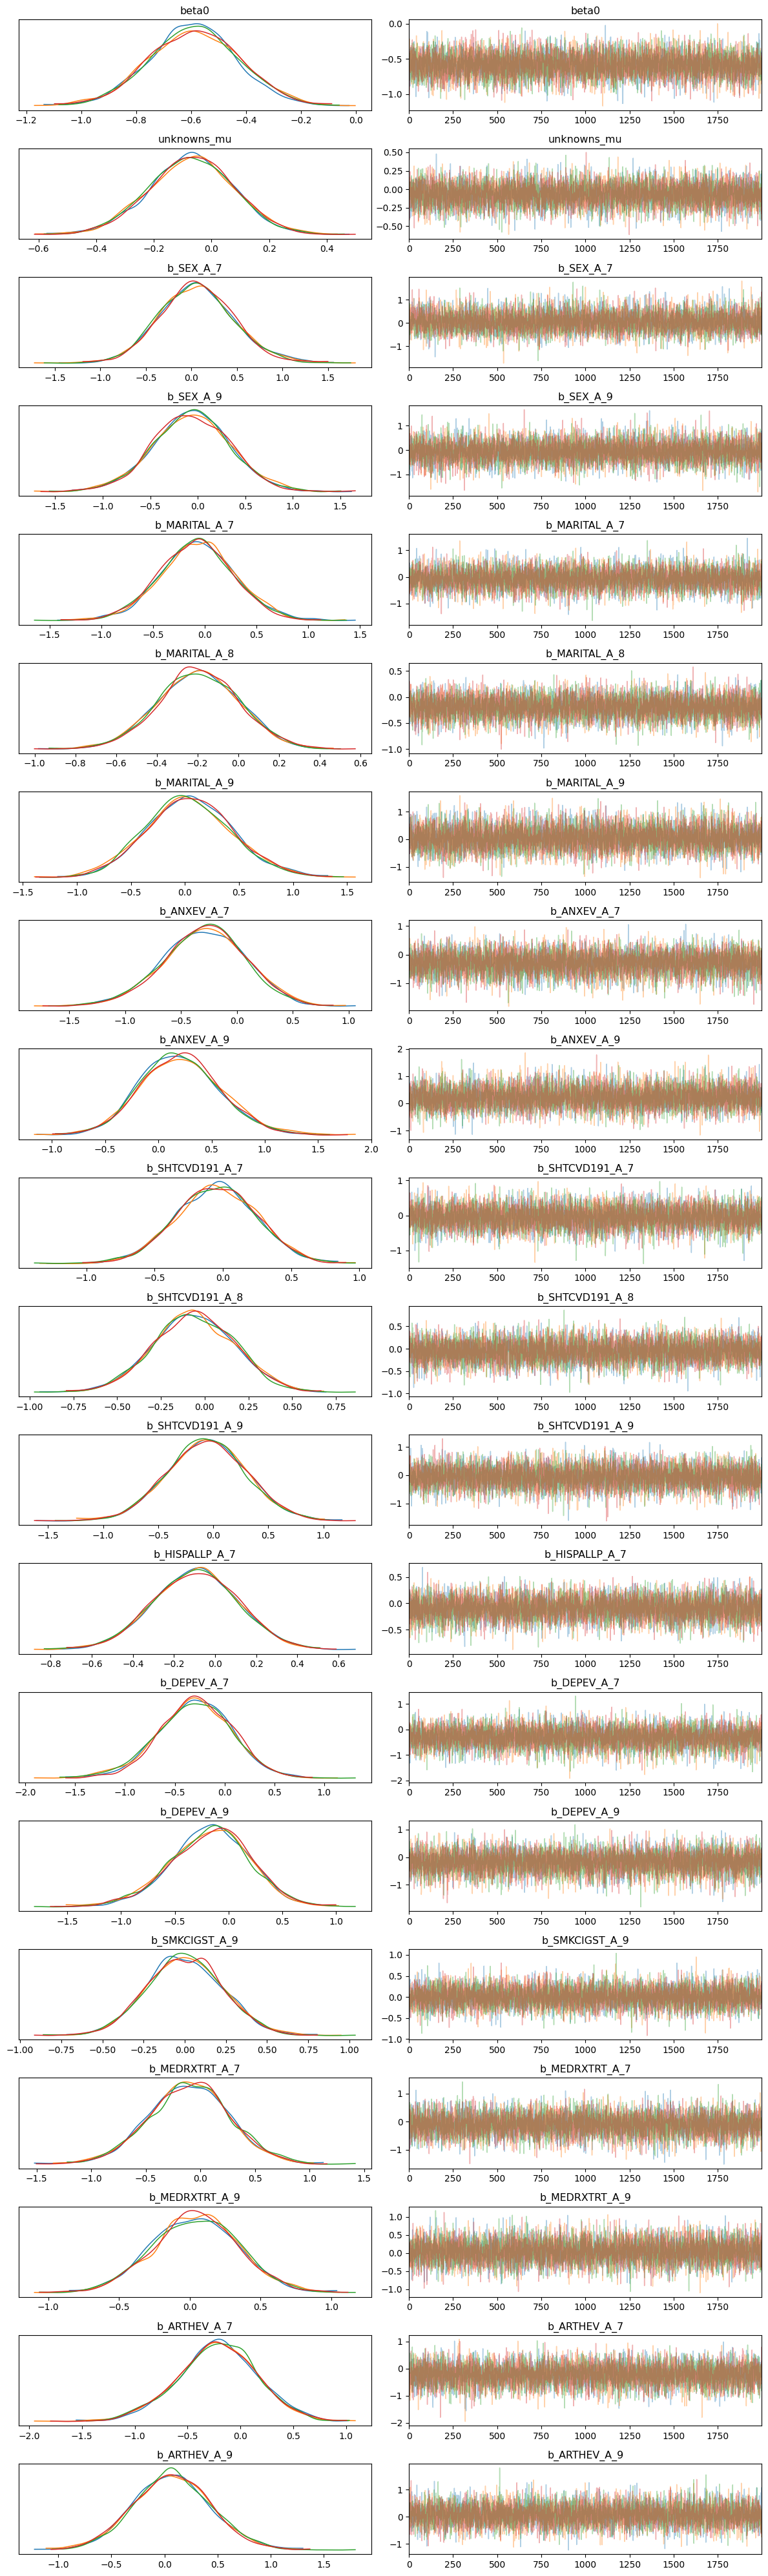

In [29]:
az.plot_trace(idata_hier_chi, compact=False);
plt.tight_layout();

In [24]:
az.summary(idata_hier_chi, var_names='b_', filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_SEX_A_7,0.060,0.412,-0.702,0.844,0.005,0.003,7818.0,7739.0,1.0
b_SEX_A_9,-0.064,0.413,-0.842,0.721,0.005,0.003,7899.0,7690.0,1.0
b_MARITAL_A_7,-0.072,0.361,-0.746,0.620,0.004,0.003,7523.0,8008.0,1.0
b_MARITAL_A_8,-0.194,0.200,-0.569,0.182,0.002,0.002,7695.0,7599.0,1.0
b_MARITAL_A_9,0.045,0.406,-0.726,0.814,0.005,0.003,7938.0,7698.0,1.0
b_ANXEV_A_7,-0.291,0.373,-0.966,0.430,0.004,0.003,7727.0,7407.0,1.0
b_ANXEV_A_9,0.209,0.379,-0.479,0.930,0.004,0.003,7966.0,7642.0,1.0
b_SHTCVD191_A_7,-0.050,0.300,-0.586,0.530,0.003,0.002,7801.0,7854.0,1.0
b_SHTCVD191_A_8,-0.059,0.232,-0.499,0.370,0.003,0.002,7949.0,7309.0,1.0
b_SHTCVD191_A_9,-0.060,0.361,-0.737,0.614,0.004,0.003,7673.0,7649.0,1.0


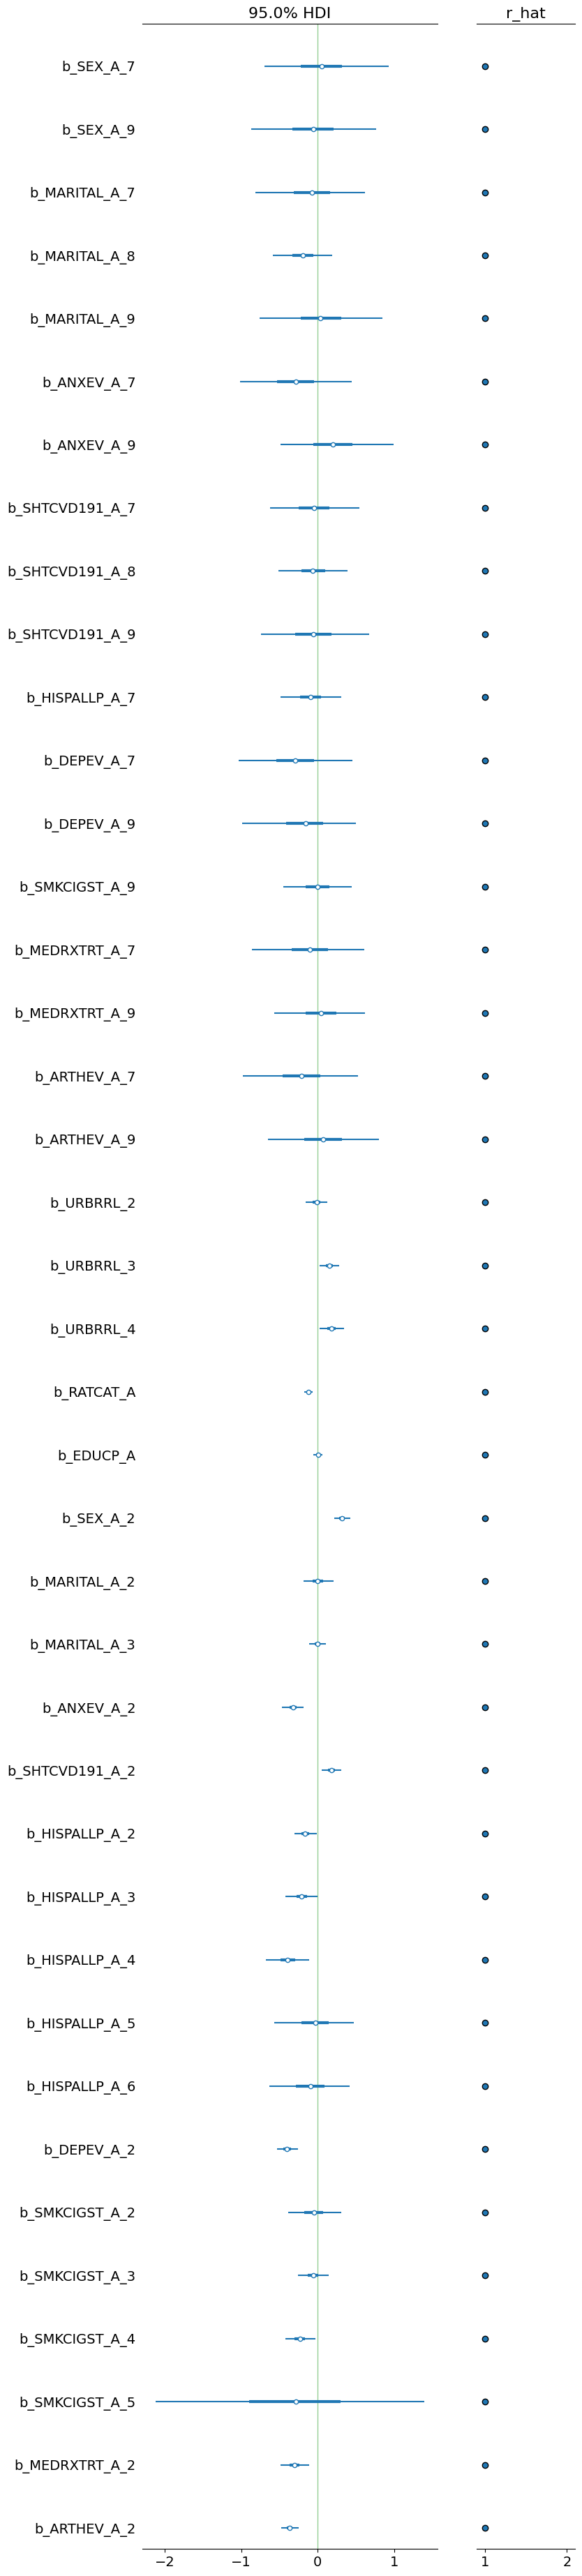

In [25]:
az.plot_forest(idata_hier_chi, var_names='b_', filter_vars="like", combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));

In [26]:
def plot_roc(y_true, p_pred, title="ROC"):
    fpr, tpr, thresholds = roc_curve(
        y_true=y_true, y_score=p_pred, pos_label=1, drop_intermediate=False
    )
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots()
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
    x = np.linspace(0,1)
    y = x
    plt.plot(x,y, linestyle='--')
    ax.set(title=title);

def get_preds(trace, y_true):
    p_pred = trace.predictions["obs"].mean(dim=["chain", "draw"])
    y_pred = (p_pred >= 0.5).astype("int").to_numpy()
    print(f"accuracy = {np.mean(y_true==y_pred): 0.3f}")

    return p_pred, y_pred

# p_train_pred, y_train_pred = get_preds(idata_hier_chi, y_train)
# plot_roc(y_train, p_train_pred, title="Simple model ROC")

In [27]:
with hier_chi_model:
    pm.set_data({"X": X_test.values, "y": y_test})
    idata_hier_chi.extend(pm.sample_posterior_predictive(idata_hier_chi))

Sampling: [obs]


Output()

accuracy =  0.843


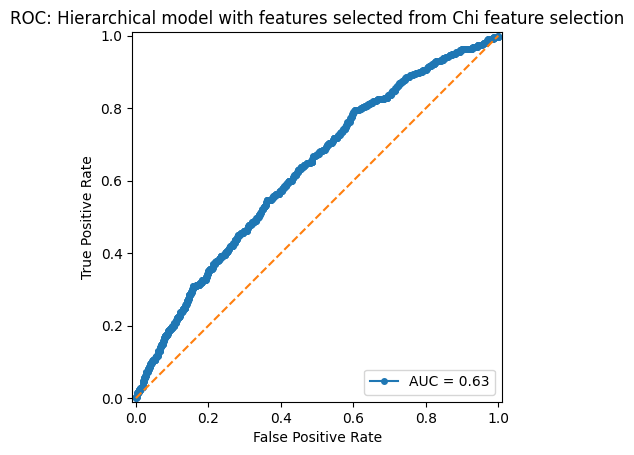

In [28]:
# ROC for Hier Ci model
p_test_pred = idata_hier_chi.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()
print(f"accuracy = {np.mean(y_test==y_test_pred): 0.3f}")
plot_roc(y_test, p_test_pred, title="ROC: Hierarchical model with features selected from Chi feature selection")

In [30]:
idata_hier_chi

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [66]:
cont_cols = ['RATCAT_A', 'EDUCP_A']
unscaled_cont = pd.DataFrame(scaler.inverse_transform(X_train[cont_cols]), columns = cont_cols)
unscaled_cont

,RATCAT_A,EDUCP_A
0,14.0,8.0
1,4.0,4.0
2,8.0,7.0
3,12.0,8.0
4,12.0,8.0
...,...,...
12227,14.0,7.0
12228,13.0,9.0
12229,10.0,8.0
12230,11.0,8.0


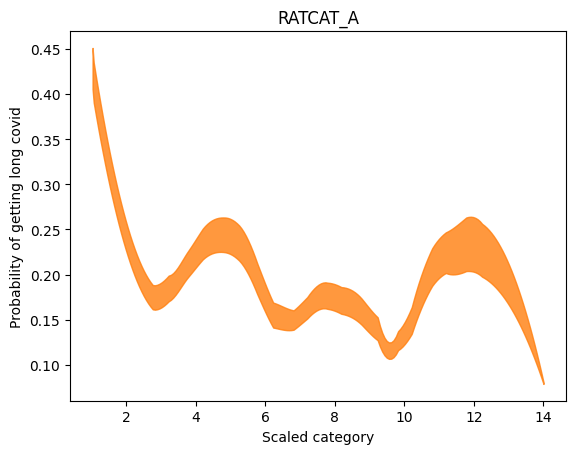

In [67]:
ax = az.plot_hdi(
    unscaled_cont.RATCAT_A, ## CHANGE
    idata_hier_chi.posterior["p"],
    hdi_prob=0.6,
    fill_kwargs={"color": "tab:orange", "alpha": 0.8},
)
ax.set_title("RATCAT_A")
ax.set_xlabel("Scaled category")
ax.set_ylabel("Probability of getting long covid")
plt.show()

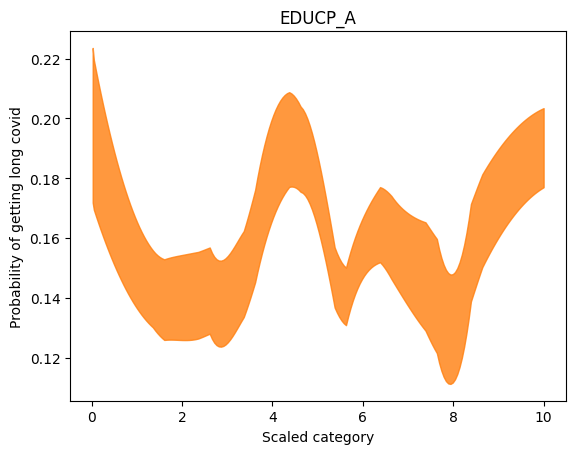

In [68]:
ax = az.plot_hdi(
    unscaled_cont.EDUCP_A, ## CHANGE
    idata_hier_chi.posterior["p"],
    hdi_prob=0.6,
    fill_kwargs={"color": "tab:orange", "alpha": 0.8},
)
ax.set_title("EDUCP_A")
ax.set_xlabel("Category")
ax.set_ylabel("Probability of getting long covid")
plt.show()